In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_pickle('/content/gdrive/MyDrive/SalesForecasting/Final_processed.pkl')
X = df['image_pixel']
y = df['high_sale']
X = X.to_numpy()
X = np.stack(X, axis=0)

<ipython-input-3-8025e9c6e938>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='high_sale', palette=['blue', 'orange'])


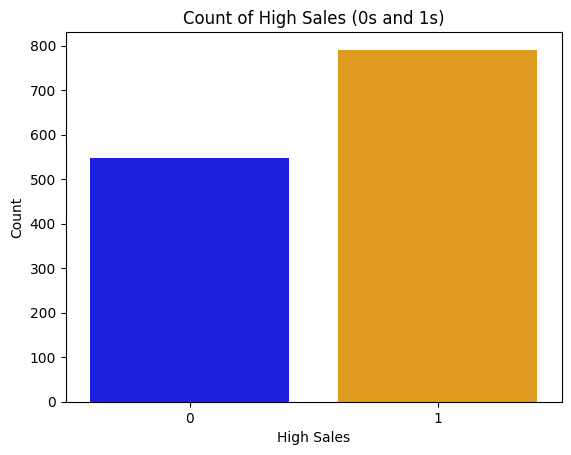

In [ ]:
# Plotting with Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='high_sale', palette=['blue', 'orange'])
plt.xlabel('High Sales')
plt.ylabel('Count')
plt.title('Count of High Sales (0s and 1s)')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

def balance_dataset(df, image_column='image_pixel'):
    """
    Balance dataset using image augmentation for images and upsampling for other features

    Args:
        df: DataFrame with image_pixel and other columns
        image_column: name of the column containing image data

    Returns:
        Balanced DataFrame
    """
    # Separate image data and other features
    X_images = np.stack(df[image_column].values)
    y = df['high_sale'].values

    # Balance images using augmentation
    X_images_balanced, y_balanced = augment_minority(X_images, y)

    # Create temporary dataframe without image column
    df_temp = df.drop(columns=[image_column])

    # Separate majority and minority classes for other features
    df_majority = df_temp[df_temp['high_sale'] == 1]
    df_minority = df_temp[df_temp['high_sale'] == 0]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)

    # Combine majority and upsampled minority
    df_numeric_balanced = pd.concat([df_majority, df_minority_upsampled])

    # Create new balanced DataFrame
    df_final = df_numeric_balanced.copy()

    # Add balanced image data
    df_final[image_column] = [img for img in X_images_balanced]

    # Shuffle the dataset
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_final

def augment_minority(X, y):
    """
    Oversample minority class using image augmentation
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #vertical_flip=False,  # Set to True if applicable for your images
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
    )

    # Find minority class
    minority_class = 0 if np.sum(y == 0) < np.sum(y == 1) else 1
    majority_class = 1 - minority_class

    # Get minority samples
    X_minority = X[y == minority_class]
    y_minority = y[y == minority_class]

    # Calculate samples needed
    n_minority = len(X_minority)
    n_majority = np.sum(y == majority_class)
    n_to_generate = n_majority - n_minority

    # Generate augmented images
    X_augmented = []
    for i in range(n_to_generate):
        idx = i % n_minority
        img = X_minority[idx:idx+1]
        augmented = next(datagen.flow(img, batch_size=1))[0]
        X_augmented.append(augmented)

    # Combine original and augmented data
    X_balanced = np.concatenate([X, np.array(X_augmented)])
    y_balanced = np.concatenate([y, np.full(n_to_generate, minority_class)])

    return X_balanced, y_balanced

# Usage
# Assuming your DataFrame is called 'df'
print("Original dataset shape:", df['high_sale'].value_counts())

# Balance the dataset
df_balanced = balance_dataset(df)

print("\nBalanced dataset shape:", df_balanced['high_sale'].value_counts())

# Verify image shapes
print("\nImage shapes in balanced dataset:")
print("First image shape:", np.stack(df_balanced['image_pixel'].iloc[0]).shape)

Original dataset shape: high_sale
1    791
0    547
Name: count, dtype: int64

Balanced dataset shape: high_sale
0    791
1    791
Name: count, dtype: int64

Image shapes in balanced dataset:
First image shape: (224, 224, 3)


<ipython-input-5-3d03cad673d4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='high_sale', palette=['blue', 'orange'])


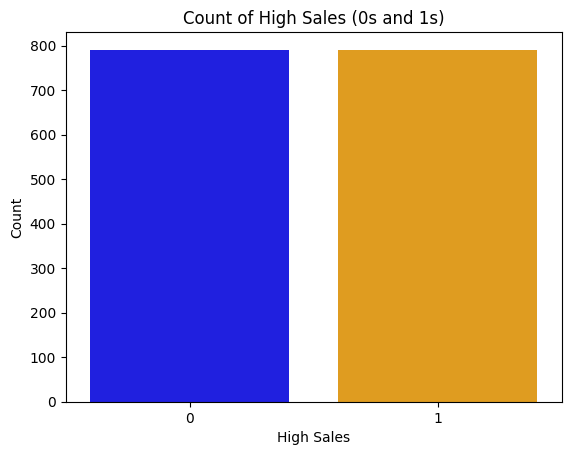

In [ ]:
# Plotting with Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_balanced, x='high_sale', palette=['blue', 'orange'])
plt.xlabel('High Sales')
plt.ylabel('Count')
plt.title('Count of High Sales (0s and 1s)')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X_balanced, y_balanced = augment_minority(X, y)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Ensure X is a numpy array and convert to float32
X = np.array(X_balanced, dtype=np.float32)

# Normalize to [0, 1] range
X = X / 255.0

# Split into 0.75:0.125:0.125
X_train, X_temp, y_train, y_temp = train_test_split(X, y_balanced, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
print ("number of training examples = " + str(X_train_balanced.shape[0]))
print ("number of val examples = " + str(X_val_balanced.shape[0]))
print ("number of test examples = " + str(X_test_balanced.shape[0]))
print ("X_train_balanced shape: " + str(X_train_balanced.shape))
print ("y_train_balanced shape: " + str(y_train_balanced.shape))
print ("X_val_balanced shape: " + str(X_val_balanced.shape))
print ("y_val_balanced shape: " + str(y_val_balanced.shape))
print ("X_test_balanced shape: " + str(X_test_balanced.shape))
print ("y_test_balanced shape: " + str(y_test_balanced.shape))

number of training examples = 1012
number of val examples = 253
number of test examples = 317
X_train_balanced shape: (1012, 224, 224, 3)
y_train_balanced shape: (1012,)
X_val_balanced shape: (253, 224, 224, 3)
y_val_balanced shape: (253,)
X_test_balanced shape: (317, 224, 224, 3)
y_test_balanced shape: (317,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define image input shape
image_input = Input(shape=(224, 224, 3), name='image')

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB3(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3))

# Freeze more layers (80% instead of 70%)
total_layers = len(base_model.layers)
for layer in base_model.layers[:int(0.8 * total_layers)]:
    layer.trainable = False

# Preprocess input
x = tf.keras.applications.efficientnet.preprocess_input(image_input)

# Add data augmentation layer (during training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
], name='augmentation')

x = data_augmentation(x)

# Pass through base model
x = base_model(x)

# Enhanced top layers with L2 regularization and reduced complexity
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# First dense layer - reduced size, added L2
x = Dense(256,
          activation='relu',
          kernel_regularizer=l2(0.01),
          bias_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second dense layer - reduced size, added L2
x = Dense(128,
          activation='relu',
          kernel_regularizer=l2(0.01),
          bias_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer
outputs = Dense(1,
                activation='sigmoid',
                kernel_regularizer=l2(0.01))(x)

# Define the model
model = Model(inputs=image_input, outputs=outputs)

# Compile with reduced learning rate and gradient clipping
optimizer = Adam(
    learning_rate=1e-4,  # Reduced learning rate
    clipnorm=1.0  # Gradient clipping
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,217,712 (42.79 MB)

 Trainable params: 6,856,377 (26.16 MB)

 Non-trainable params: 4,361,335 (16.64 MB)

In [ ]:
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
]

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=50,
    batch_size=16,  # Try smaller batch size
    callbacks=callbacks,
    class_weight={  # Add class weights if still imbalanced
        0: 1.,
        1: 1.
    }
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.4691 - loss: 7.1886 - val_accuracy: 0.4980 - val_loss: 6.7128 - learning_rate: 1.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.5719 - loss: 6.9132 - val_accuracy: 0.5257 - val_loss: 6.6237 - learning_rate: 1.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.5529 - loss: 6.7882 - val_accuracy: 0.5455 - val_loss: 6.5225 - learning_rate: 1.0000e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.6064 - loss: 6.6095 - val_accuracy: 0.5850 - val_loss: 6.4342 - learning_rate: 1.0000e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.6207 - loss: 6.4629 - val_accuracy: 0.5968 - val_loss: 6.3607 - learning_rate: 1.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.6188 - loss: 6.3821 - val_accuracy: 0.6166 - val_loss: 6.2883 - learning_rate: 1.0000e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.6899 


Model Accuracy Results:
Final Training Accuracy: 0.8725
Final Validation Accuracy: 0.7036


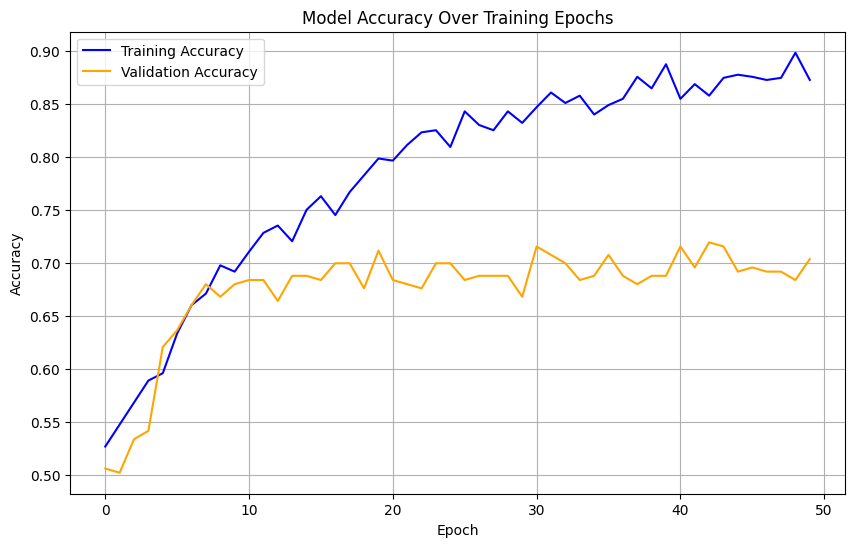

In [ ]:
# Get accuracy from training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Print final accuracy scores
print("\nModel Accuracy Results:")
print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

# Plot accuracy over time to visualize learning progress
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Training Accuracy', color='blue')
plt.plot(validation_accuracy, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,217,712 (42.79 MB)

 Trainable params: 430,337 (1.64 MB)

 Non-trainable params: 10,787,375 (41.15 MB)

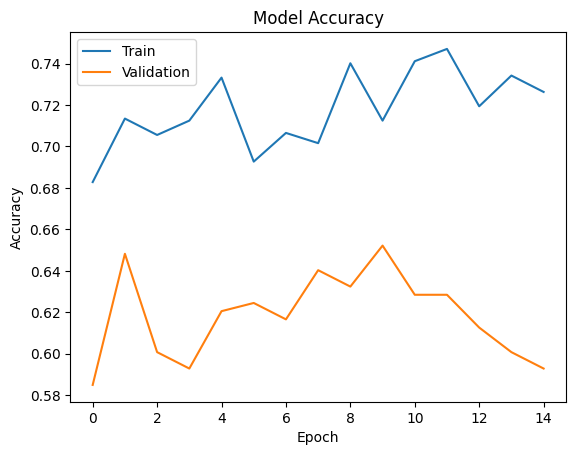

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Change 'validation_accuracy' to 'val_accuracy'
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


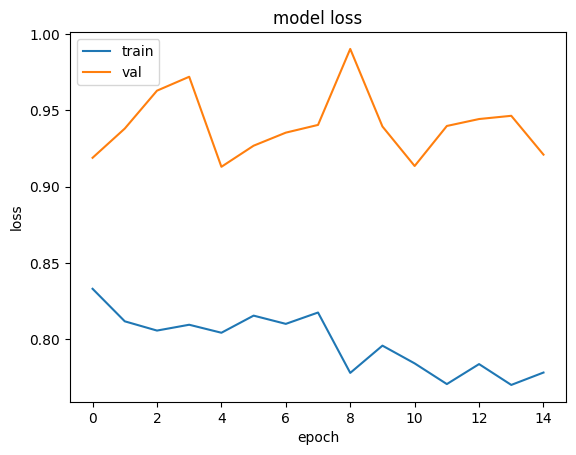

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load EfficientNetB0 with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Data Preparation
# Assuming X_train_balanced, y_train_balanced, X_val_balanced, y_val_balanced are already defined

# 3. Model Creation
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Assuming binary classification

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile Model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 5. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Training
history = model.fit(
    datagen.flow(X_train_balanced, y_train_balanced, batch_size=32),
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=50,  # Increase epochs, early stopping will prevent overfitting
    callbacks=[reduce_lr, early_stop]
)

# 7. Evaluation
test_loss, test_accuracy = model.evaluate(X_test_balanced, y_test_balanced)
print(f"Test accuracy: {test_accuracy:.4f}")

# 8. Predictions (if needed)
predictions = model.predict(X_test_balanced)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/18 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.5172 - loss: 0.7181

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_balanced, y_test_balanced),
    epochs=10,
    batch_size=32
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9352 - loss: 0.0770 - val_accuracy: 0.6484 - val_loss: 0.2724
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 168ms/step - accuracy: 0.8394 - loss: 0.1537 - val_accuracy: 0.6505 - val_loss: 0.2908
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.8853 - loss: 0.1087 - val_accuracy: 0.6463 - val_loss: 0.2263
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9128 - loss: 0.0984 - val_accuracy: 0.5937 - val_loss: 0.2700
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9423 - loss: 0.0671 - val_accuracy: 0.6695 - val_loss: 0.2555
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9486 - loss: 0.0636 - val_accuracy: 0.6253 - val_loss: 0.2416
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9322 - loss: 0.0594 - val_accuracy: 0.6442 - val_loss: 0.2516
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9461 - loss: 0.0492 - val_accuracy: 0.


Model Accuracy Results:
Final Training Accuracy: 0.9168
Final Validation Accuracy: 0.6779


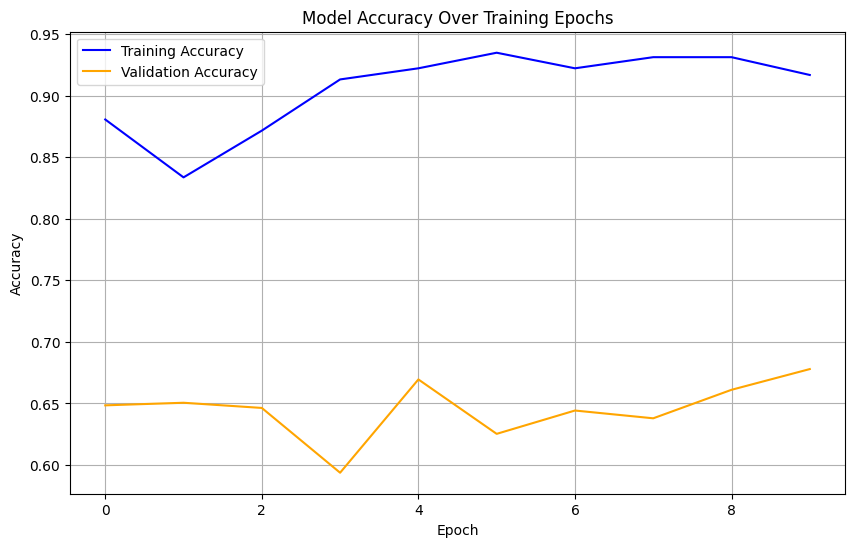

In [ ]:
# Get accuracy from training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Print final accuracy scores
print("\nModel Accuracy Results:")
print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

# Plot accuracy over time to visualize learning progress
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Training Accuracy', color='blue')
plt.plot(validation_accuracy, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()